In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.model import *
from script.loss import *

# Config

In [10]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/pseud_ashcolor_4label"
    train_label_path = f"{dataset_path}/labels/model1_iter_0/"
    new_label_path = f"{dataset_path}/labels/model1_iter_1/"
    train_model_path = ["/kaggle/working/notebook/experiment/v2/model22/model22/model22.pth",
                        "/kaggle/working/notebook/experiment/v2/model22/model22/model22.pth",]
    exp_name = os.getcwd().split('/')[-1]
    exp_description = "pseudo_ashcolor_4label_iter1"

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest200e'
    in_chans = 3
    target_size = 4
    fold = 2

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 50
    if debug:
        epochs = 20

    lr = 1e-4
    loss = "DiceLoss"
    smooth = 300

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5, rotate_limit=(10, 10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)
pd.set_option('display.max_rows', 500)
pd.options.display.max_colwidth = 300

# Dataset

In [5]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")
valid_df = valid_df.dropna()

train_df_true_label = train_df[~train_df["label_path"].isnull()]
train_df_pseud_label = train_df[train_df["label_path"].isnull()]

fill_path = CFG.train_label_path + train_df["record_id"].astype("str") + "_"+train_df["time"].astype("str")+".npy"
train_df_pseud_label["label_path"] = fill_path

train_df_true_label.loc[:, "fold"] = -1

kf = KFold(n_splits=CFG.fold, random_state=42, shuffle=True)
train_df_pseud_label.loc[:, "fold"] = None
for i, fold in enumerate(kf.split(train_df_pseud_label)):
    train_df_pseud_label["fold"].iloc[fold[1]] = i

train_df = pd.concat([train_df_pseud_label, train_df_true_label], axis=0).sort_values(by=["record_id", "time"]).reset_index(drop=True)

if CFG.debug:
    train_df=train_df[:200]
    valid_df=valid_df[:200]
train_df.shape, valid_df.shape
train_df.head(10)

,record_id,image_path,time,label_path,fold
0,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_0.npy,0,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/iter_0/195731008142151_0.npy,0
1,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_1.npy,1,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/iter_0/195731008142151_1.npy,1
2,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_2.npy,2,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/iter_0/195731008142151_2.npy,1
3,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_3.npy,3,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/iter_0/195731008142151_3.npy,0
4,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_4.npy,4,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/true/195731008142151_4.npy,-1
5,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_5.npy,5,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/iter_0/195731008142151_5.npy,1
6,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_6.npy,6,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/iter_0/195731008142151_6.npy,0
7,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_7.npy,7,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/iter_0/195731008142151_7.npy,1
8,1108741208571075,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/1108741208571075_0.npy,0,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/iter_0/1108741208571075_0.npy,1
9,1108741208571075,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/1108741208571075_1.npy,1,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/iter_0/1108741208571075_1.npy,0


In [6]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list, "pseudo_train")
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list, "pseudo_train")

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(10, dataset_train)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/iter_0/195731008142151_0.npy'

# Training

In [6]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

for fold in range(CFG.fold):
    print(f"fold : {fold}\n")
    dataset_train = ContrailsDataset(train_df[train_df["fold"] != fold], CFG.train_aug_list, "pseudo_train")
    dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size, shuffle=True, num_workers=CFG.num_workers)

    model, dice_score, thresh = load_model(CFG.train_model_path[fold])
    print(f"model_dice_score:  {dice_score:.4f}")
    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))
    model = nn.DataParallel(model, device_ids=device_ids)

    scaler = amp.GradScaler()
    criterion = smp.losses.DiceLoss(mode="multilabel", smooth=CFG.smooth)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)
    thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

    dice_score = 0
    slacknotify=SlackNotify(f"{CFG.exp_description} fold: {fold}")
    for epoch in range(CFG.epochs):
        model.train()

        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
        loss_train, loss_val = 0.0, 0.0
        for i, (images, masks) in pbar_train:
            images, masks = images.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():
                preds = model(images)
                loss = criterion(preds, masks)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                loss_train += loss.detach().item()

            lr = f"LR : {scheduler.get_lr()[0]:.2E}"
            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                  f"Loss: {loss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()

        cum_pred = []
        cum_true = []
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        for i, (images, masks) in pbar_val:
            images, masks = images.cuda(), masks.cuda()
            with torch.no_grad():
                preds = model(images)[:, 2]
                loss_val += criterion(preds, masks).item()
                preds = torch.sigmoid(preds)
                cum_pred.append(preds.cpu().detach().numpy())
                cum_true.append(masks.cpu().detach().numpy())

            pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))

        cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
        cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))

        dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)

        if dice_score_ > dice_score:
            print(f"score : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {dice_score_:.4f}\tBEST")
            epoch_best = epoch
            dice_score = dice_score_
            torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                        "model_arch": CFG.model_arch, "backbone": CFG.backbone, "in_chans": CFG.in_chans, "target_size": CFG.target_size,},
                       f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth')
        else:
            print(f"score : {dice_score_:.4f}\tthresh : {thresh}\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {dice_score_:.4f}")

    slacknotify.send_reply(f" {CFG.exp_description} training finished\tbest score : {dice_score}", True)
    break

fold : 0



model_arch:  Unet
backbone:  timm-resnest200e
model_dice_score:  0.6675


Epoch 0/100  Mem : 15.1GB  LR : 1.00E-04  Loss: 0.2415: 100%|██████████| 2887/2887 [16:16<00:00,  2.96it/s]
Val Loss: 0.0279: 100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


score : 0.6635	thresh : 0.41	SAVED MODEL



Epoch 1/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2771: 100%|██████████| 2887/2887 [16:00<00:00,  3.01it/s]
Val Loss: 0.0314: 100%|██████████| 58/58 [00:14<00:00,  4.10it/s]


score : 0.6456	thresh : 0.99



Epoch 2/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2732: 100%|██████████| 2887/2887 [16:19<00:00,  2.95it/s]
Val Loss: 0.0393: 100%|██████████| 58/58 [00:13<00:00,  4.21it/s]


score : 0.5377	thresh : 0.25



Epoch 3/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2732: 100%|██████████| 2887/2887 [15:57<00:00,  3.01it/s]
Val Loss: 0.0282: 100%|██████████| 58/58 [00:13<00:00,  4.23it/s]


score : 0.6476	thresh : 0.01



Epoch 4/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2705: 100%|██████████| 2887/2887 [15:57<00:00,  3.02it/s]
Val Loss: 0.0409: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.5287	thresh : 0.81



Epoch 5/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2663: 100%|██████████| 2887/2887 [15:56<00:00,  3.02it/s]
Val Loss: 0.0289: 100%|██████████| 58/58 [00:13<00:00,  4.37it/s]


score : 0.6505	thresh : 0.47



Epoch 6/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2660: 100%|██████████| 2887/2887 [16:04<00:00,  2.99it/s]
Val Loss: 0.0284: 100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


score : 0.6518	thresh : 0.13



Epoch 7/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2636: 100%|██████████| 2887/2887 [15:47<00:00,  3.05it/s]
Val Loss: 0.0286: 100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


score : 0.6515	thresh : 0.01



Epoch 8/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2617: 100%|██████████| 2887/2887 [15:57<00:00,  3.01it/s]
Val Loss: 0.0285: 100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


score : 0.6526	thresh : 0.15



Epoch 9/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2599: 100%|██████████| 2887/2887 [15:57<00:00,  3.01it/s]
Val Loss: 0.0297: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6534	thresh : 0.99



Epoch 10/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2590: 100%|██████████| 2887/2887 [16:25<00:00,  2.93it/s]
Val Loss: 0.0283: 100%|██████████| 58/58 [00:13<00:00,  4.23it/s]


score : 0.6560	thresh : 0.17



Epoch 11/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2588: 100%|██████████| 2887/2887 [16:16<00:00,  2.96it/s]
Val Loss: 0.0306: 100%|██████████| 58/58 [00:13<00:00,  4.18it/s]


score : 0.6526	thresh : 0.99



Epoch 12/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2581: 100%|██████████| 2887/2887 [16:21<00:00,  2.94it/s]
Val Loss: 0.0305: 100%|██████████| 58/58 [00:14<00:00,  4.11it/s]


score : 0.6461	thresh : 0.99



Epoch 13/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2559: 100%|██████████| 2887/2887 [16:10<00:00,  2.98it/s]
Val Loss: 0.0278: 100%|██████████| 58/58 [00:13<00:00,  4.29it/s]


score : 0.6476	thresh : 0.01



Epoch 14/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2534: 100%|██████████| 2887/2887 [16:06<00:00,  2.99it/s]
Val Loss: 0.0408: 100%|██████████| 58/58 [00:13<00:00,  4.29it/s]


score : 0.5561	thresh : 0.99



Epoch 15/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2521: 100%|██████████| 2887/2887 [16:20<00:00,  2.94it/s]
Val Loss: 0.0300: 100%|██████████| 58/58 [00:14<00:00,  4.12it/s]


score : 0.6571	thresh : 0.99



Epoch 16/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2533: 100%|██████████| 2887/2887 [16:18<00:00,  2.95it/s]
Val Loss: 0.0306: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6248	thresh : 0.99



Epoch 17/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2511: 100%|██████████| 2887/2887 [16:27<00:00,  2.92it/s]
Val Loss: 0.0275: 100%|██████████| 58/58 [00:13<00:00,  4.25it/s]


score : 0.6585	thresh : 0.01



Epoch 18/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2489: 100%|██████████| 2887/2887 [16:36<00:00,  2.90it/s]
Val Loss: 0.0300: 100%|██████████| 58/58 [00:14<00:00,  4.11it/s]


score : 0.6551	thresh : 0.99



Epoch 19/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2495: 100%|██████████| 2887/2887 [16:27<00:00,  2.92it/s]
Val Loss: 0.0291: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]


score : 0.6558	thresh : 0.91



Epoch 20/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2483: 100%|██████████| 2887/2887 [16:06<00:00,  2.99it/s]
Val Loss: 0.0305: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6329	thresh : 0.95



Epoch 21/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2472: 100%|██████████| 2887/2887 [15:52<00:00,  3.03it/s]
Val Loss: 0.0291: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6594	thresh : 0.97



Epoch 22/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2468: 100%|██████████| 2887/2887 [15:57<00:00,  3.02it/s]
Val Loss: 0.0295: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6589	thresh : 0.99



Epoch 23/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2459: 100%|██████████| 2887/2887 [15:47<00:00,  3.05it/s]
Val Loss: 0.0282: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6529	thresh : 0.01



Epoch 24/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2452: 100%|██████████| 2887/2887 [15:51<00:00,  3.04it/s]
Val Loss: 0.0283: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6583	thresh : 0.01



Epoch 25/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2452: 100%|██████████| 2887/2887 [15:57<00:00,  3.02it/s]
Val Loss: 0.0312: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6365	thresh : 0.99



Epoch 26/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2437: 100%|██████████| 2887/2887 [15:52<00:00,  3.03it/s]
Val Loss: 0.0291: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6643	thresh : 0.99	SAVED MODEL



Epoch 27/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2439: 100%|██████████| 2887/2887 [15:57<00:00,  3.02it/s]
Val Loss: 0.0444: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.5269	thresh : 0.99



Epoch 28/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2435: 100%|██████████| 2887/2887 [15:52<00:00,  3.03it/s]
Val Loss: 0.0299: 100%|██████████| 58/58 [00:13<00:00,  4.29it/s]


score : 0.6522	thresh : 0.99



Epoch 29/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2419: 100%|██████████| 2887/2887 [15:56<00:00,  3.02it/s]
Val Loss: 0.0282: 100%|██████████| 58/58 [00:13<00:00,  4.17it/s]


score : 0.6601	thresh : 0.77



Epoch 30/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2425: 100%|██████████| 2887/2887 [15:59<00:00,  3.01it/s]
Val Loss: 0.0598: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.4472	thresh : 0.99



Epoch 31/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2393: 100%|██████████| 2887/2887 [15:51<00:00,  3.03it/s]
Val Loss: 0.0292: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6613	thresh : 0.99



Epoch 32/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2413: 100%|██████████| 2887/2887 [15:52<00:00,  3.03it/s]
Val Loss: 0.0280: 100%|██████████| 58/58 [00:13<00:00,  4.28it/s]


score : 0.6565	thresh : 0.01



Epoch 33/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2391: 100%|██████████| 2887/2887 [15:53<00:00,  3.03it/s]
Val Loss: 0.0276: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]


score : 0.6701	thresh : 0.79	SAVED MODEL



Epoch 34/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2400: 100%|██████████| 2887/2887 [15:53<00:00,  3.03it/s]
Val Loss: 0.0284: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]


score : 0.6588	thresh : 0.39



Epoch 35/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2392: 100%|██████████| 2887/2887 [15:56<00:00,  3.02it/s]
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6609	thresh : 0.95



Epoch 36/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2353: 100%|██████████| 2887/2887 [15:54<00:00,  3.02it/s]
Val Loss: 0.0286: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6648	thresh : 0.99



Epoch 37/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2378: 100%|██████████| 2887/2887 [15:52<00:00,  3.03it/s]
Val Loss: 0.0284: 100%|██████████| 58/58 [00:13<00:00,  4.29it/s]


score : 0.6642	thresh : 0.95



Epoch 38/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2358: 100%|██████████| 2887/2887 [15:54<00:00,  3.02it/s]
Val Loss: 0.0276: 100%|██████████| 58/58 [00:13<00:00,  4.28it/s]


score : 0.6676	thresh : 0.13



Epoch 39/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2349: 100%|██████████| 2887/2887 [15:56<00:00,  3.02it/s]
Val Loss: 0.0291: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6530	thresh : 0.87



Epoch 40/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2349: 100%|██████████| 2887/2887 [15:49<00:00,  3.04it/s]
Val Loss: 0.0282: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]


score : 0.6669	thresh : 0.97



Epoch 41/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2337: 100%|██████████| 2887/2887 [15:56<00:00,  3.02it/s]
Val Loss: 0.0282: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6653	thresh : 0.69



Epoch 42/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2340: 100%|██████████| 2887/2887 [15:54<00:00,  3.02it/s]
Val Loss: 0.0283: 100%|██████████| 58/58 [00:13<00:00,  4.29it/s]


score : 0.6655	thresh : 0.91



Epoch 43/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2332: 100%|██████████| 2887/2887 [15:56<00:00,  3.02it/s]
Val Loss: 0.0276: 100%|██████████| 58/58 [00:13<00:00,  4.28it/s]


score : 0.6616	thresh : 0.03



Epoch 44/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2322: 100%|██████████| 2887/2887 [15:52<00:00,  3.03it/s]
Val Loss: 0.0282: 100%|██████████| 58/58 [00:13<00:00,  4.29it/s]


score : 0.6660	thresh : 0.77



Epoch 45/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2316: 100%|██████████| 2887/2887 [15:55<00:00,  3.02it/s]
Val Loss: 0.0273: 100%|██████████| 58/58 [00:13<00:00,  4.29it/s]


score : 0.6678	thresh : 0.01



Epoch 46/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2298: 100%|██████████| 2887/2887 [15:57<00:00,  3.02it/s]
Val Loss: 0.0280: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6663	thresh : 0.67



Epoch 47/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2303: 100%|██████████| 2887/2887 [16:05<00:00,  2.99it/s]
Val Loss: 0.0283: 100%|██████████| 58/58 [00:13<00:00,  4.21it/s]


score : 0.6686	thresh : 0.99



Epoch 48/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2298: 100%|██████████| 2887/2887 [16:33<00:00,  2.90it/s]
Val Loss: 0.0280: 100%|██████████| 58/58 [00:14<00:00,  4.14it/s]


score : 0.6638	thresh : 0.47



Epoch 49/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2280: 100%|██████████| 2887/2887 [16:17<00:00,  2.95it/s]
Val Loss: 0.0290: 100%|██████████| 58/58 [00:13<00:00,  4.14it/s]


score : 0.6612	thresh : 0.99



Epoch 50/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2283: 100%|██████████| 2887/2887 [16:20<00:00,  2.94it/s]
Val Loss: 0.0269: 100%|██████████| 58/58 [00:14<00:00,  4.08it/s]


score : 0.6700	thresh : 0.01



Epoch 51/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2279: 100%|██████████| 2887/2887 [16:29<00:00,  2.92it/s]
Val Loss: 0.0286: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]


score : 0.6652	thresh : 0.99



Epoch 52/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2268: 100%|██████████| 2887/2887 [16:17<00:00,  2.95it/s]
Val Loss: 0.0286: 100%|██████████| 58/58 [00:13<00:00,  4.25it/s]


score : 0.6682	thresh : 0.99



Epoch 53/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2276: 100%|██████████| 2887/2887 [16:27<00:00,  2.92it/s]
Val Loss: 0.0268: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6693	thresh : 0.01



Epoch 54/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2248: 100%|██████████| 2887/2887 [16:07<00:00,  2.98it/s]
Val Loss: 0.0287: 100%|██████████| 58/58 [00:13<00:00,  4.39it/s]


score : 0.6657	thresh : 0.99



Epoch 55/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2246: 100%|██████████| 2887/2887 [16:06<00:00,  2.99it/s]
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


score : 0.6690	thresh : 0.99



Epoch 56/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2239: 100%|██████████| 2887/2887 [16:04<00:00,  2.99it/s]
Val Loss: 0.0272: 100%|██████████| 58/58 [00:13<00:00,  4.42it/s]


score : 0.6744	thresh : 0.87	SAVED MODEL



Epoch 57/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2238: 100%|██████████| 2887/2887 [16:12<00:00,  2.97it/s]
Val Loss: 0.0272: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6701	thresh : 0.13



Epoch 58/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2230: 100%|██████████| 2887/2887 [16:09<00:00,  2.98it/s]
Val Loss: 0.0283: 100%|██████████| 58/58 [00:13<00:00,  4.39it/s]


score : 0.6701	thresh : 0.99



Epoch 59/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2220: 100%|██████████| 2887/2887 [16:02<00:00,  3.00it/s]
Val Loss: 0.0273: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6765	thresh : 0.73	SAVED MODEL



Epoch 60/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2210: 100%|██████████| 2887/2887 [16:03<00:00,  3.00it/s]
Val Loss: 0.0276: 100%|██████████| 58/58 [00:13<00:00,  4.37it/s]


score : 0.6750	thresh : 0.93



Epoch 61/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2203: 100%|██████████| 2887/2887 [16:02<00:00,  3.00it/s]
Val Loss: 0.0272: 100%|██████████| 58/58 [00:13<00:00,  4.38it/s]


score : 0.6775	thresh : 0.93	SAVED MODEL



Epoch 62/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2202: 100%|██████████| 2887/2887 [16:08<00:00,  2.98it/s]
Val Loss: 0.0274: 100%|██████████| 58/58 [00:13<00:00,  4.39it/s]


score : 0.6724	thresh : 0.61



Epoch 63/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2188: 100%|██████████| 2887/2887 [16:03<00:00,  3.00it/s]
Val Loss: 0.0275: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6720	thresh : 0.57



Epoch 64/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2178: 100%|██████████| 2887/2887 [16:00<00:00,  3.00it/s]
Val Loss: 0.0286: 100%|██████████| 58/58 [00:13<00:00,  4.38it/s]


score : 0.6668	thresh : 0.99



Epoch 65/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2179: 100%|██████████| 2887/2887 [16:06<00:00,  2.99it/s]
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


score : 0.6619	thresh : 0.99



Epoch 66/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2165: 100%|██████████| 2887/2887 [16:05<00:00,  2.99it/s]
Val Loss: 0.0282: 100%|██████████| 58/58 [00:13<00:00,  4.41it/s]


score : 0.6664	thresh : 0.95



Epoch 67/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2173: 100%|██████████| 2887/2887 [16:00<00:00,  3.01it/s]
Val Loss: 0.0310: 100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


score : 0.6478	thresh : 0.99



Epoch 68/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2151: 100%|██████████| 2887/2887 [16:06<00:00,  2.99it/s]
Val Loss: 0.0282: 100%|██████████| 58/58 [00:13<00:00,  4.44it/s]


score : 0.6687	thresh : 0.99



Epoch 69/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2152: 100%|██████████| 2887/2887 [16:01<00:00,  3.00it/s]
Val Loss: 0.0271: 100%|██████████| 58/58 [00:13<00:00,  4.44it/s]


score : 0.6738	thresh : 0.33



Epoch 70/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2142: 100%|██████████| 2887/2887 [16:02<00:00,  3.00it/s]
Val Loss: 0.0270: 100%|██████████| 58/58 [00:12<00:00,  4.47it/s]


score : 0.6746	thresh : 0.85



Epoch 71/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2135: 100%|██████████| 2887/2887 [16:11<00:00,  2.97it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6784	thresh : 0.15	SAVED MODEL



Epoch 72/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2136: 100%|██████████| 2887/2887 [16:15<00:00,  2.96it/s]
Val Loss: 0.0269: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6768	thresh : 0.09



Epoch 73/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2130: 100%|██████████| 2887/2887 [16:12<00:00,  2.97it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6775	thresh : 0.73



Epoch 74/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2128: 100%|██████████| 2887/2887 [16:08<00:00,  2.98it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.29it/s]


score : 0.6793	thresh : 0.55	SAVED MODEL



Epoch 75/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2113: 100%|██████████| 2887/2887 [16:01<00:00,  3.00it/s]
Val Loss: 0.0277: 100%|██████████| 58/58 [00:13<00:00,  4.28it/s]


score : 0.6667	thresh : 0.99



Epoch 76/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2110: 100%|██████████| 2887/2887 [16:43<00:00,  2.88it/s]
Val Loss: 0.0270: 100%|██████████| 58/58 [00:13<00:00,  4.23it/s]


score : 0.6767	thresh : 0.91



Epoch 77/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2109: 100%|██████████| 2887/2887 [15:57<00:00,  3.02it/s]
Val Loss: 0.0268: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6783	thresh : 0.59



Epoch 78/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2099: 100%|██████████| 2887/2887 [15:58<00:00,  3.01it/s]
Val Loss: 0.0263: 100%|██████████| 58/58 [00:13<00:00,  4.24it/s]


score : 0.6787	thresh : 0.01



Epoch 79/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2091: 100%|██████████| 2887/2887 [16:02<00:00,  3.00it/s]
Val Loss: 0.0275: 100%|██████████| 58/58 [00:13<00:00,  4.26it/s]


score : 0.6760	thresh : 0.97



Epoch 80/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2087: 100%|██████████| 2887/2887 [15:59<00:00,  3.01it/s]
Val Loss: 0.0283: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]


score : 0.6621	thresh : 0.99



Epoch 81/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2086: 100%|██████████| 2887/2887 [15:59<00:00,  3.01it/s]
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.29it/s]


score : 0.6632	thresh : 0.99



Epoch 82/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2081: 100%|██████████| 2887/2887 [15:58<00:00,  3.01it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]


score : 0.6790	thresh : 0.23



Epoch 83/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2075: 100%|██████████| 2887/2887 [15:57<00:00,  3.01it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6807	thresh : 0.59	SAVED MODEL



Epoch 84/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2069: 100%|██████████| 2887/2887 [15:58<00:00,  3.01it/s]
Val Loss: 0.0269: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6790	thresh : 0.95



Epoch 85/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2069: 100%|██████████| 2887/2887 [15:57<00:00,  3.02it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6789	thresh : 0.77



Epoch 86/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2057: 100%|██████████| 2887/2887 [15:54<00:00,  3.02it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6786	thresh : 0.25



Epoch 87/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2064: 100%|██████████| 2887/2887 [15:52<00:00,  3.03it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]


score : 0.6793	thresh : 0.77



Epoch 88/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2057: 100%|██████████| 2887/2887 [16:02<00:00,  3.00it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.18it/s]


score : 0.6801	thresh : 0.65



Epoch 89/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2055: 100%|██████████| 2887/2887 [16:25<00:00,  2.93it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6797	thresh : 0.31



Epoch 90/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2051: 100%|██████████| 2887/2887 [16:04<00:00,  2.99it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6799	thresh : 0.57



Epoch 91/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2056: 100%|██████████| 2887/2887 [16:08<00:00,  2.98it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6796	thresh : 0.21



Epoch 92/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2048: 100%|██████████| 2887/2887 [16:08<00:00,  2.98it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6799	thresh : 0.39



Epoch 93/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2046: 100%|██████████| 2887/2887 [16:08<00:00,  2.98it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6804	thresh : 0.47



Epoch 94/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2047: 100%|██████████| 2887/2887 [16:05<00:00,  2.99it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.21it/s]


score : 0.6800	thresh : 0.35



Epoch 95/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2050: 100%|██████████| 2887/2887 [16:07<00:00,  2.98it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6790	thresh : 0.23



Epoch 96/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2041: 100%|██████████| 2887/2887 [16:06<00:00,  2.99it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6812	thresh : 0.27	SAVED MODEL



Epoch 97/100  Mem : 15.1GB  LR : 1.00E-03  Loss: 0.2031:  21%|██        | 593/2887 [03:21<12:57,  2.95it/s]


KeyboardInterrupt: 

# Pseudo Labelling

In [11]:
def pseudo_inference(dataloader_label, model, thresh, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, (images, record_ids, times) in tqdm(enumerate(dataloader_label), total=len(dataloader_label)):
        images = images.cuda()
        with torch.no_grad():
            preds = model(images)
        preds = torch.sigmoid(preds).cpu().detach().numpy()
        preds_thresh = np.where(preds > thresh, 1, 0)

        for num in range(images.shape[0]):
            pred = preds_thresh[num, :, :, :].transpose(1, 2, 0)
            record_id = int(record_ids[num])
            time = int(times[num])
            save_path = f"{save_dir}/{record_id}_{time}.npy"
            np.save(save_path, pred)

In [12]:
for fold in range(CFG.fold):
    label_df = train_df[train_df["fold"] == fold]

    dataset_label = ContrailsDataset(label_df, CFG.valid_aug_list, "pseudo_labeling")
    dataloader_label = DataLoader(dataset_label, batch_size=CFG.valid_batch_size, num_workers=CFG.num_workers)

    model_path = sorted(glob(f"./{CFG.exp_name}/*.pth"))[fold]
    model, dice_score, thresh = load_model(model_path)
    model.eval()
    print(f"{dice_score = :.4f}")
    print(f"{thresh = }")

    pseudo_inference(dataloader_label, model, thresh, CFG.new_label_path)

model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6812
thresh = 0.27


100%|██████████| 2246/2246 [1:12:29<00:00,  1.94s/it]


model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6777
thresh = 0.91


100%|██████████| 2246/2246 [1:21:07<00:00,  2.17s/it]


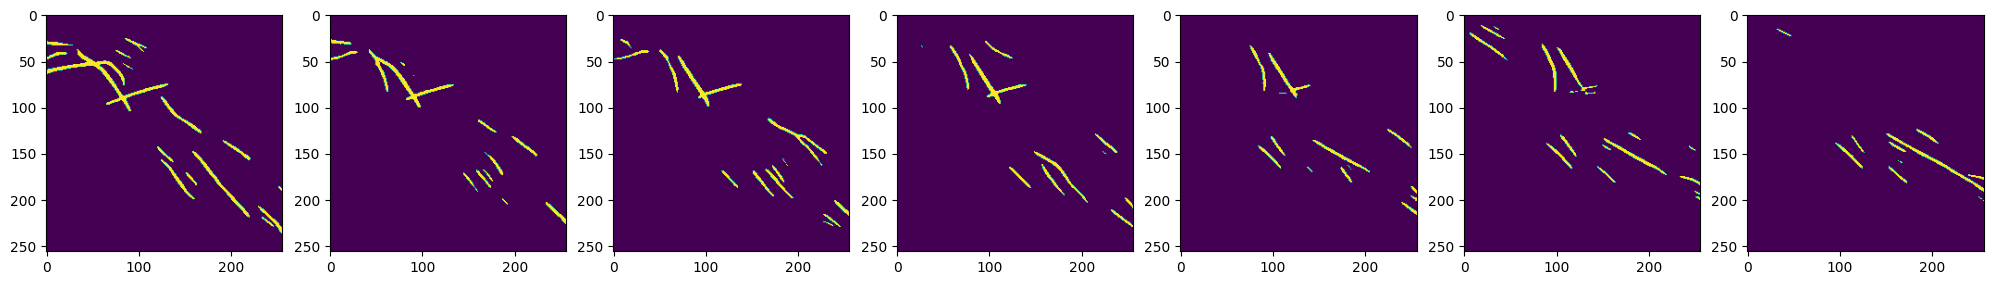

In [18]:
no = 16
id = os.listdir(CFG.new_label_path)[no*7].split("_")[0]
fig, ax = plt.subplots(1, 7, figsize=(25, 10))
for i, time in enumerate([0, 1, 2, 3, 5, 6, 7]):
    npy = np.load(f"{CFG.new_label_path}/{id}_{time}.npy")
    ax[i].imshow(npy)

In [25]:
label_df = train_df[train_df["fold"] == -1]

dataset_label = ContrailsDataset(label_df, CFG.valid_aug_list, "pseudo_labeling")
dataloader_label = DataLoader(dataset_label, batch_size=CFG.valid_batch_size, num_workers=CFG.num_workers)

model_path = sorted(glob(f"./{CFG.exp_name}/*.pth"))[0]
model, dice_score, thresh = load_model(model_path)
model.eval()
print(f"{dice_score = :.4f}")
print(f"{thresh = }")

pseudo_inference(dataloader_label, model, thresh, "/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/valid")

model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6812
thresh = 0.27


 77%|███████▋  | 494/642 [18:21<05:30,  2.23s/it]


KeyboardInterrupt: 